# Project

## Dépendance

In [7]:
! pip install SPARQLWrapper
! pip install exifread
! pip install pandas
! pip install PIL
! pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 24.1 will enforce t

## Collecte de données

In [8]:
import pandas as pd
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get cities
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q1549591;
               wdt:P17 ?pays;
               wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 15"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["grandevilleLabel"]["value"],
            result["paysLabel"]["value"],
            result["image"]["value"],
        )
    )

dataframe = pd.DataFrame(array, columns=["ville", "pays", "image"])
dataframe = dataframe.astype(
    dtype={"ville": "<U200", "pays": "<U200", "image": "<U200"}
)
dataframe

,ville,pays,image
0,Pskov,Russie,http://commons.wikimedia.org/wiki/Special:File...
1,Copenhague,Danemark,http://commons.wikimedia.org/wiki/Special:File...
2,Québec,Canada,http://commons.wikimedia.org/wiki/Special:File...
3,Pune,Inde,http://commons.wikimedia.org/wiki/Special:File...
4,Riazan,Russie,http://commons.wikimedia.org/wiki/Special:File...
5,Erfurt,Allemagne,http://commons.wikimedia.org/wiki/Special:File...
6,Djouba,Soudan du Sud,http://commons.wikimedia.org/wiki/Special:File...
7,Edmonton,Canada,http://commons.wikimedia.org/wiki/Special:File...
8,Victoria,Canada,http://commons.wikimedia.org/wiki/Special:File...
9,Francfort-sur-le-Main,Allemagne,http://commons.wikimedia.org/wiki/Special:File...


### Téléchargement des images

In [9]:
import requests
import shutil
import os

def download_image(url):
    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        # Create 'images' directory if it doesn't exist
        if not os.path.exists("images"):
            os.makedirs("images")

        # Extract the filename from the URL and save the image in 'images' directory
        filename = os.path.join("images", os.path.basename(url))
        with open(filename, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

def clear_images_directory():
    # Clear 'images' directory if it exists
    if os.path.exists("images"):
        shutil.rmtree("images")

# Clear 'images' directory before every execution
clear_images_directory()

# Assuming 'dataframe' is a DataFrame containing URLs under column 'image'
# Apply the download_image function to each URL in the 'image' column
dataframe.image.apply(download_image)

0     200
1     200
2     200
3     200
4     200
5     200
6     200
7     200
8     200
9     200
10    200
11    200
12    200
13    200
14    200
Name: image, dtype: int64

### Enregistrement des métadonnées
#### Import

In [4]:
import os
import json
from PIL import Image, TiffImagePlugin
import PIL.ExifTags
import pandas as pd
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

#### Define the directory path and initialize the list to store metadata:

In [2]:
directory_path = "images"
all_metadata = []

if not os.path.isdir(directory_path):
    print(f"Error: Directory '{directory_path}' does not exist!")
    sys.exit()

#### Define the function to cast data types

In [3]:
def cast(v):
    if isinstance(v, TiffImagePlugin.IFDRational):
        if v.denominator == 0:
            return None  # Handle division by zero gracefully
        return float(v.numerator) / float(v.denominator)
    elif isinstance(v, tuple):
        return tuple(cast(t) for t in v)
    elif isinstance(v, bytes):
        return v.decode(errors="replace")
    elif isinstance(v, dict):
        for kk, vv in v.items():
            v[kk] = cast(vv)
        return v
    else:
        return v

#### Define the function to get main colors

In [4]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans

def get_main_colors(image_path, num_clusters):
    # Open and resize the image
    imgfile = image_path
    imgfile.thumbnail((100, 100))  # Resize the image to a smaller size
    numarray = np.array(imgfile)  # Convert image to numpy array

    # Flatten the image array
    numarray = numarray.reshape((-1, 3))

    # Sample a subset of pixels (optional)
    np.random.shuffle(numarray)
    num_samples = min(10000, len(numarray))  # Adjust the number of samples if needed
    numarray = numarray[:num_samples]

    # Perform KMeans clustering
    clusters = KMeans(n_clusters=num_clusters, n_init=2)
    clusters.fit(numarray)

    # Get the main colors
    main_colors = clusters.cluster_centers_.astype(int)

    return main_colors.tolist()  # Convert array to list


In [5]:
import numpy as np

# Function to find the closest main color for a given RGB value
def find_closest_color(rgb):
    main_colors = [
        [0, 0, 0],      # Black
        [255, 255, 255],  # White
        [255, 0, 0],    # Red
        [0, 255, 0],    # Green
        [0, 0, 255],    # Blue
        [255, 255, 0],  # Yellow
        [255, 0, 255],  # Magenta
        [0, 255, 255],  # Cyan
        [128, 128, 128], # Grey
        [255, 165, 0],   # Orange
        [0, 128, 0],     # Dark Green
        [128, 0, 128],   # Purple
        [128, 0, 0],     # Maroon
        [0, 128, 128],   # Teal
        [128, 128, 0],   # Olive
        [0, 255, 255],   # Light Blue
        [210, 105, 30],  # Chocolate
        [139, 69, 19],   # Saddle Brown
        [255, 192, 203], # Pink
        [0, 0, 128],     # Navy
        [220, 20, 60]    # Crimson
        # Add more main colors as needed
    ]

    # Convert list of main colors to numpy array for vectorized calculations
    main_colors = np.array(main_colors)

    # Convert input RGB list to numpy array
    rgb = np.array(rgb)

    # Calculate Euclidean distances between input RGB and all main colors
    distances = np.linalg.norm(main_colors - rgb, axis=1)

    # Find index of the closest main color
    closest_index = np.argmin(distances)

    return main_colors[closest_index].tolist()  # Convert NumPy array to list


In [6]:
def classify_image_size(image_size):
    """
    Classify the image into different size classes based on its dimensions.

    Parameters:
        image_size (tuple): The dimensions of the image in the format (width, height).

    Returns:
        str: The class label for the image size.
    """
    width, height = image_size

    # Define size thresholds for different classes
    small_threshold = 500  # threshold for small images
    medium_threshold = 1000  # threshold for medium images

    # Classify the image based on its dimensions
    if width <= small_threshold or height <= small_threshold:
        return "Small"
    elif width <= medium_threshold or height <= medium_threshold:
        return "Medium"
    else:
        return "Large"

#### Define the function to get the images properties

In [7]:
def get_image_metadata(imgfile, hasExif):
    """
    Get metadata of an image file including format, size, main colors, closest colors, and orientation.

    Parameters:
        imgfile (PIL.Image.Image): The image file object.
        hasExif (bool): Indicates whether the image has Exif metadata.

    Returns:
        dict: Metadata of the image.
    """
    metadata = {}

    # Get image format
    metadata['format'] = imgfile.format

    # Get image size
    metadata['size'] = imgfile.size

    # Classify image size
    image_size = imgfile.size
    metadata['size_class'] = classify_image_size(image_size)

    # Get 3 main colors
    main_colors = get_main_colors(imgfile, 3)
    metadata["main_colors"] = main_colors

    # Get closest colors based on the 3 main colors
    closest_colors = [find_closest_color(color) for color in main_colors]
    metadata["closest_colors"] = closest_colors

    # Get image orientation
    if hasExif:
        exif = dict(imgfile._getexif().items())
        if exif:
            orientation = exif.get(274)
            if orientation == 1:
                metadata['orientation'] = 'Landscape'
            elif orientation == 3:
                metadata['orientation'] = 'Portrait'
            else:
                metadata['orientation'] = 'Unknown'
        else:
            metadata['orientation'] = 'Unknown'
    else:
        metadata['orientation'] = 'Unknown'

    return metadata

#### Loop through files in the directory and extract metadata

It will also add as tags the format, the size and the 3 main colors

In [8]:
import os
import json
import sys
from PIL import Image, TiffImagePlugin
import PIL.ExifTags

directory_path = "images"
all_metadata = []

if not os.path.isdir(directory_path):
    print(f"Error: Directory '{directory_path}' does not exist!")
    sys.exit()

for filename in os.listdir(directory_path):
    if os.path.isfile(os.path.join(directory_path, filename)) and filename.lower().endswith((".jpg", ".png")):
        print(f"Found image: {filename}")

        try:
            imgfile = Image.open(os.path.join(directory_path, filename))
            exif_data = imgfile._getexif()
            
            metadata_dict = {}
            
            hasExif = False

            if exif_data:
                hasExif = True
                for k, v in imgfile._getexif().items():
                    if k in PIL.ExifTags.TAGS:
                        v = cast(v)
                        metadata_dict[PIL.ExifTags.TAGS[k]] = v
            else:
                print(f"  - No EXIF data found for {filename}")

            # Get additional image metadata (format, size, orientation)
            image_metadata = get_image_metadata(imgfile, hasExif)
            metadata_dict.update(image_metadata)
            
            all_metadata.append({filename: metadata_dict})
            if not metadata_dict:
                print(f"  - No metadata found for {filename}")

        except Exception as e:
            print(f"  - Error processing {filename}: {e}")

directory_path = "output"
output_file = "directory_metadata.json"

if not os.path.exists(directory_path):
            os.makedirs(directory_path)

output_location = directory_path + "/" + output_file
with open(output_location, "w") as json_file:
    json.dump(all_metadata, json_file, indent=4)

print(f"Directory metadata saved to {output_location} (if no errors occurred)")


Found image: Ch%C3%A2teau%20Frontenac%2C%20Quebec%20city%2C%20Canada.jpg
Found image: Havenwelten%20%C3%9Cberblick%20Bremerhaven%202013.jpg
Found image: Concepcion-Chile%28001%29.jpg
  - No EXIF data found for Concepcion-Chile%28001%29.jpg
Found image: Innenstadt%20Leipzig%20mit%20Thomaskirche%20von%20Panorama%20Tower%202013.jpg
Found image: %D0%A4%D0%B5%D1%81%D1%82%D0%B8%D0%B2%D0%B0%D0%BB%D1%8C%20%D0%B2%D0%BE%D0%B7%D0%B4%D1%83%D1%85%D0%BE%D0%BF%D0%BB%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F%20%D0%B2%20%D0%A0%D1%8F%D0%B7%D0%B0%D0%BD%D0%B8.jpg
Found image: Juba%20City.jpg
Found image: Downtown%20edmonton.jpg
Found image: Frankfurter%20Altstadt%20mit%20Skyline%202019%20%28100MP%29.jpg


/home/warmteapot/.local/lib/python3.9/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (99998272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Found image: Copenhagen%20-%20view%20from%20Christiansborg%20castle.jpg
Found image: Petrozavodsk%20Collage%202020.png
  - No EXIF data found for Petrozavodsk%20Collage%202020.png
  - Error processing Petrozavodsk%20Collage%202020.png: cannot reshape array of size 28400 into shape (3)
Found image: Erfurt%20cathedral%20and%20severi%20church-2.jpg
  - No EXIF data found for Erfurt%20cathedral%20and%20severi%20church-2.jpg
Found image: Bras%C3%ADlia%20Collage.png
  - No EXIF data found for Bras%C3%ADlia%20Collage.png
  - Error processing Bras%C3%ADlia%20Collage.png: cannot reshape array of size 24800 into shape (3)
Found image: Pskov%20asv07-2018%20Kremlin%20before%20sunset.jpg
Found image: Shaniwar%20Wada%20Main%20Gate%2001.jpg
Found image: Victoria%20Montage%202020.jpg
Directory metadata saved to output/directory_metadata.json (if no errors occurred)


## Étiquetage et annotation
### Utilisation des utilisateur pour tagger les images

In [5]:
from os import listdir
import ipywidgets as widgets
from ipywidgets import GridspecLayout

images = []

# Loop through files in the "./images" directory
for file in listdir("./images"):
    # Check if the file is a PNG or JPG image
    if file.endswith((".png", ".jpg")):
        images.append("./images/" + file)
        
values = []

# Create text boxes
text_boxes = [widgets.Text(value='', description='Tag:') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(images), width='400px')
for i, (img, text_box) in enumerate(zip(images, text_boxes)):
    with open(img, "rb") as file:
        image = file.read()
    image_widget = widgets.Image(
        value=image,
        format='png',
        width=100,
        height=100,
    )
    layout[i,0] = image_widget
    layout[i, 1] = text_box

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected values
output = widgets.Output()

# Function to get selected values
def get_selected_values(btn):
    global values
    values = []
    selected_values = [(file.split("/")[-1], text_box.value) for file, text_box in zip(images, text_boxes) if text_box.value]
    with output:
        output.clear_output()
        print("Selected Values:")
        for file_name, value in selected_values:
            print(f"{file_name}: {value}")
            values.append((file_name, value))
    print(values)
        

# Link button click event to function
button.on_click(get_selected_values)

# Display the layout and button
display(layout, button, output)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1(WExif\x00\x00II*\x00\x08\x00\x00\x00\x10\x00\x00\x01\x…

Button(description='Select', style=ButtonStyle())

Output()

In [4]:
import json

# Load the existing JSON file
with open('output/directory_metadata.json', 'r') as file:
    json_data = json.load(file)

# Iterate through the values and update the JSON data
for file_name, value in values:
    # Search for the corresponding object in the JSON data
    for obj in json_data:
        for filename, details in obj.items():
            # Check if the file name matches
            if filename == file_name:
                # Update the value
                details['tag'] = value
                break  # Exit inner loop if match found
        else:
            continue  # Continue to next iteration if no match found
        break  # Exit outer loop if match found

# Save the updated JSON data back to the file
with open('output/directory_metadata.json', 'w') as file:
    json.dump(json_data, file, indent=4)

## Analyses de données

In [1]:
from os import listdir
import ipywidgets as widgets
from ipywidgets import GridspecLayout

# Get the list of images in the "./images" directory
images = []
for file in listdir("./images"):
    if file.endswith((".png", ".jpg")):
        images.append(file)

# Create checkboxes for each image
checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(images), width='400px')
for i, (image_name, checkbox) in enumerate(zip(images, checkboxes)):
    with open(f"./images/{image_name}", "rb") as file:
        image_data = file.read()
    image_widget = widgets.Image(
        value=image_data,
        format='png',
        width=100,
        height=100,
    )
    layout[i, 0] = image_widget
    layout[i, 1] = checkbox

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Function to get selected images
def get_selected_images(btn):
    global selected_image_names
    selected_image_names = [images[i] for i, checkbox in enumerate(checkboxes) if checkbox.value]
    with output:
        output.clear_output()
        print("Selected Image Names:")
        for image_name in selected_image_names:
            print(image_name)
    print(selected_image_names)

# Link button click event to function
button.on_click(get_selected_images)

# Display the layout and button
display(layout, button, output)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1(WExif\x00\x00II*\x00\x08\x00\x00\x00\x10\x00\x00\x01\x…

Button(description='Select', style=ButtonStyle())

Output()

['Ch%C3%A2teau%20Frontenac%2C%20Quebec%20city%2C%20Canada.jpg', 'Havenwelten%20%C3%9Cberblick%20Bremerhaven%202013.jpg', 'Concepcion-Chile%28001%29.jpg', 'Juba%20City.jpg', 'Downtown%20edmonton.jpg', 'Frankfurter%20Altstadt%20mit%20Skyline%202019%20%28100MP%29.jpg', 'Petrozavodsk%20Collage%202020.png', 'Pskov%20asv07-2018%20Kremlin%20before%20sunset.jpg', 'Shaniwar%20Wada%20Main%20Gate%2001.jpg']


In [9]:
import json
import os

def extract_properties(image_filenames, json_data):
    properties = []
    for filename in image_filenames:
        for obj in json_data:
            for key, details in obj.items():
                if key == filename:
                    image_properties = {
                        'filename': filename,
                        'make': details.get('Make', ''),
                        'model': details.get('Model', ''),
                        'format': details.get('format', ''),
                        'size_class': details.get('size_class', ''),
                        'closest_colors': details.get('closest_colors', []),
                        'orientation': details.get('orientation', ''),
                        'tag': details.get('tag', '')
                    }
                    properties.append(image_properties)
    return properties

def save_user_properties(username, selected_image_names, json_data):
    # Extract properties
    extracted_properties = extract_properties(selected_image_names, json_data)

    # JSON object to store user and properties
    user_properties = {
        'username': username,
        'properties': extracted_properties
    }

    # Load existing user properties or initialize an empty list
    if os.path.isfile('user_properties.json') and os.path.getsize('user_properties.json') > 0:
        with open('user_properties.json', 'r') as file:
            all_users_properties = json.load(file)
    else:
        all_users_properties = []

    # Add or update user properties
    user_exists = False
    for user_data in all_users_properties:
        if user_data['username'] == username:
            user_data['properties'] = extracted_properties
            user_exists = True
            break

    if not user_exists:
        all_users_properties.append(user_properties)

    # Write all user properties to the JSON file
    with open('user_properties.json', 'w') as file:
        json.dump(all_users_properties, file, indent=4)

    print(f"User properties for {username} have been saved to 'user_properties.json'")

# Load JSON data from file
with open('output/directory_metadata.json', 'r') as file:
    try:
        json_data = json.load(file)
    except json.decoder.JSONDecodeError:
        json_data = []

# Sample image filenames for user1 (replace with your list of selected image names)
user1_image_names = ['Ch%C3%A2teau%20Frontenac%2C%20Quebec%20city%2C%20Canada.jpg', 
                     'Havenwelten%20%C3%9Cberblick%20Bremerhaven%202013.jpg', 
                     'Copenhagen%20-%20view%20from%20Christiansborg%20castle.jpg']

# Save properties for user1
save_user_properties('user41', user1_image_names, json_data)

# Sample image filenames for user2 (replace with your list of selected image names)
user2_image_names = ['Petrozavodsk%20Collage%202020.png', 
                     'Bras%C3%ADlia%20Collage.png', 
                     'Pskov%20asv07-2018%20Kremlin%20before%20sunset.jpg']

# Save properties for user2
save_user_properties('user42', user2_image_names, json_data)


User properties for user41 have been saved to 'user_properties.json'
User properties for user42 have been saved to 'user_properties.json'


In [167]:
import os
import random
import string

def generate_users_and_properties(num_users, image_folder, max_images_per_user):
    # List files in the image folder
    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    for i in range(num_users):
        # Generate a random username
        username = ''.join(random.choices(string.ascii_letters + string.digits, k=8))

        # Select a random number of images for this user
        num_images = random.randint(1, max_images_per_user)
        selected_images = random.sample(image_files, num_images)

        # Call save_user_properties function
        save_user_properties(username, selected_images, json_data)

generate_users_and_properties(5, 'images', 10)  # Generates 5 users, each with up to 3 random images from the 'images' folder

User properties for K5bv6Ppw have been saved to 'user_properties.json'
User properties for xtMljA0M have been saved to 'user_properties.json'
User properties for hNFFNN9G have been saved to 'user_properties.json'
User properties for qwMG243E have been saved to 'user_properties.json'
User properties for mGfWAjMb have been saved to 'user_properties.json'


In [168]:
import json

def extract_image_properties_with_favorite(directory_metadata, user_properties):
    image_properties_list = []

    for entry in directory_metadata:
        filename, details = list(entry.items())[0]
        image_properties = {
            'filename': filename,
            'make': details.get('Make', ''),
            'model': details.get('Model', ''),
            'format': details.get('format', ''),
            'size_class': details.get('size_class', ''),
            'closest_colors': details.get('closest_colors', []),
            'orientation': details.get('orientation', ''),
            'tag': details.get('tag', '')
        }

        # Check if the image filename is present in user's properties
        for user in user_properties:
            if user["username"] == 'hNFFNN9G':
                for prop in user['properties']:
                    if prop['filename'] == filename:
                        image_properties['favorite'] = 'Favorite'
                        break
                else:
                    continue
                break
        else:
            image_properties['favorite'] = 'NotFavorite'

        image_properties_list.append(image_properties)

    return image_properties_list

# Load directory metadata from JSON file
with open('output/directory_metadata.json', 'r') as file:
    directory_metadata = json.load(file)

# Load user properties from JSON file
with open('user_properties.json', 'r') as file:
    user_properties = json.load(file)

# Extract image properties with favorite status
image_properties_with_favorite = extract_image_properties_with_favorite(directory_metadata, user_properties)
print(image_properties_with_favorite)


[{'filename': 'Ch%C3%A2teau%20Frontenac%2C%20Quebec%20city%2C%20Canada.jpg', 'make': 'NIKON CORPORATION', 'model': 'NIKON D7200', 'format': 'JPEG', 'size_class': 'Large', 'closest_colors': [[128, 128, 128], [128, 128, 128], [139, 69, 19]], 'orientation': 'Landscape', 'tag': '', 'favorite': 'Favorite'}, {'filename': 'Havenwelten%20%C3%9Cberblick%20Bremerhaven%202013.jpg', 'make': 'NIKON CORPORATION', 'model': 'NIKON D7000', 'format': 'JPEG', 'size_class': 'Large', 'closest_colors': [[255, 192, 203], [139, 69, 19], [128, 128, 128]], 'orientation': 'Unknown', 'tag': '', 'favorite': 'Favorite'}, {'filename': 'Concepcion-Chile%28001%29.jpg', 'make': '', 'model': '', 'format': 'JPEG', 'size_class': 'Large', 'closest_colors': [[255, 255, 255], [128, 128, 128], [0, 0, 0]], 'orientation': 'Unknown', 'tag': '', 'favorite': 'Favorite'}, {'filename': 'Innenstadt%20Leipzig%20mit%20Thomaskirche%20von%20Panorama%20Tower%202013.jpg', 'make': 'NIKON CORPORATION', 'model': 'NIKON D7000', 'format': 'JPEG

In [169]:
from sklearn import tree
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import graphviz
import pydotplus
from IPython.display import Image, display

def transform_data(input_data):
    data = []
    result = []

    for item in input_data:
        make = item['make']
        model = item['model']
        format = item['format']
        size_class = item['size_class']
        closest_colors = item['closest_colors']  # Assuming list of colors
        orientation = item['orientation']
        tag = item['tag']
        favorite = item['favorite']

        # Assuming you have 3 color values in the list
        color1, color2, color3 = closest_colors

        # No string conversion needed, use color values directly
        data.append([make, model, format, size_class, color1, color2, color3, orientation, tag])
        result.append(favorite)

    return data, result

# Example usage:
input_data = image_properties_with_favorite

data, result = transform_data(input_data)

# Create DataFrame
column_names = ["make", "model", "format", "size_class", "color1", "color2", "color3", "orientation", "tag"]
dataframe = pd.DataFrame(data, columns=column_names)

# Convert color lists to strings
dataframe["color1"] = dataframe["color1"].astype(str)
dataframe["color2"] = dataframe["color2"].astype(str)
dataframe["color3"] = dataframe["color3"].astype(str)

# Initialize LabelEncoders
le_make = LabelEncoder()
le_model = LabelEncoder()
le_format = LabelEncoder()
le_size_class = LabelEncoder()
le_color1 = LabelEncoder()
le_color2 = LabelEncoder()
le_color3 = LabelEncoder()
le_orientation = LabelEncoder()
le_tag = LabelEncoder()
le_favorite = LabelEncoder()

# Fit and transform categorical features
dataframe["make"] = le_make.fit_transform(dataframe["make"])
dataframe["model"] = le_model.fit_transform(dataframe["model"])
dataframe["format"] = le_format.fit_transform(dataframe["format"])
dataframe["size_class"] = le_size_class.fit_transform(dataframe["size_class"])
dataframe["color1"] = le_color1.fit_transform(dataframe["color1"])
dataframe["color2"] = le_color2.fit_transform(dataframe["color2"])
dataframe["color3"] = le_color3.fit_transform(dataframe["color3"])
dataframe["orientation"] = le_orientation.fit_transform(dataframe["orientation"])
dataframe["tag"] = le_tag.fit_transform(dataframe["tag"])

# Create DataFrame for favorite column
resultframe = pd.DataFrame(result, columns=["favorite"])

# Convert 'favorite' to numerical labels
resultframe["favorite"] = le_favorite.fit_transform(resultframe["favorite"])

# Use of random forest classifier
rfc = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
rfc = rfc.fit(dataframe.values, resultframe.values.ravel())

for item in input_data:
    predicted_make = item['make']
    predicted_model = item['model']
    predicted_format = item['format']
    predicted_size_class = item['size_class']
    closest_colors = item['closest_colors']  # Assuming list of colors
    predicted_orientation = item['orientation']
    predicted_tag = item['tag']

    # Assuming you have 3 color values in the list
    color1, color2, color3 = closest_colors
    # Prediction with handling unseen colors (optional)
    try:
        prediction = rfc.predict([
            [
                le_make.transform([predicted_make])[0],
                le_model.transform([predicted_model])[0],
                le_format.transform([predicted_format])[0],
                le_size_class.transform([predicted_size_class])[0],
                le_color1.transform([str(color1)])[0],
                le_color2.transform([str(color2)])[0],
                le_color3.transform([str(color3)])[0],
                le_orientation.transform([predicted_orientation])[0],
                le_tag.transform([predicted_tag])[0],
            ]
        ])
    except ValueError as e:
        # Handle unseen color values (e.g., predict default favorite)
        print(f"Encountered unseen color values: {e}")
        prediction = [0]  # Example: predict default favorite (adjust based on your logic)
    print(item["filename"])
    print(le_favorite.inverse_transform(prediction))
    # print(rfc.feature_importances_)


filtered_data = [{'filename': item['filename'], 'favorite': item['favorite']} for item in input_data]
print(filtered_data)

Ch%C3%A2teau%20Frontenac%2C%20Quebec%20city%2C%20Canada.jpg
['Favorite']
Havenwelten%20%C3%9Cberblick%20Bremerhaven%202013.jpg
['Favorite']
Concepcion-Chile%28001%29.jpg
['Favorite']
Innenstadt%20Leipzig%20mit%20Thomaskirche%20von%20Panorama%20Tower%202013.jpg
['NotFavorite']
%D0%A4%D0%B5%D1%81%D1%82%D0%B8%D0%B2%D0%B0%D0%BB%D1%8C%20%D0%B2%D0%BE%D0%B7%D0%B4%D1%83%D1%85%D0%BE%D0%BF%D0%BB%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F%20%D0%B2%20%D0%A0%D1%8F%D0%B7%D0%B0%D0%BD%D0%B8.jpg
['Favorite']
Juba%20City.jpg
['NotFavorite']
Downtown%20edmonton.jpg
['Favorite']
Frankfurter%20Altstadt%20mit%20Skyline%202019%20%28100MP%29.jpg
['Favorite']
Copenhagen%20-%20view%20from%20Christiansborg%20castle.jpg
['NotFavorite']
Erfurt%20cathedral%20and%20severi%20church-2.jpg
['NotFavorite']
Pskov%20asv07-2018%20Kremlin%20before%20sunset.jpg
['Favorite']
Shaniwar%20Wada%20Main%20Gate%2001.jpg
['NotFavorite']
Victoria%20Montage%202020.jpg
['NotFavorite']
[{'filename': 'Ch%C3%A2teau%20Frontenac%2C%20Quebec%20city%

## Visualisation des données

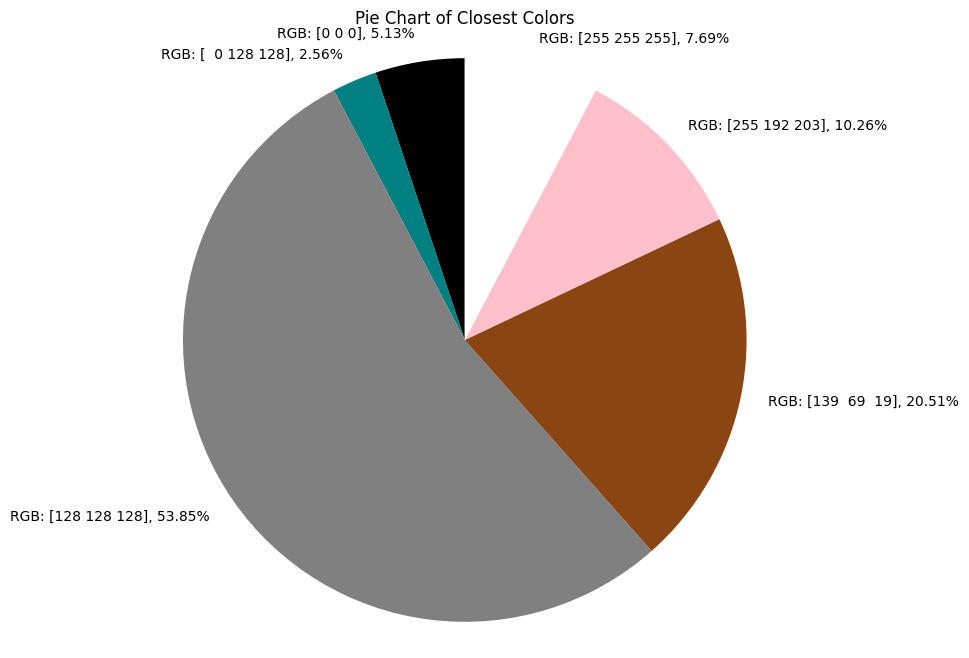

In [163]:
import json
import matplotlib.pyplot as plt

# Open the JSON file
with open('output/directory_metadata.json', 'r') as file:
    # Load the JSON data
    json_data = json.load(file)

    # Create a list to store all the closest colors
    all_closest_colors = []

    # Iterate through each object in the list
    for obj in json_data:
        # Get the dictionary within each object
        for filename, details in obj.items():
            # Access the "closest_colors" key within each dictionary
            closest_colors = details.get("closest_colors")
            if closest_colors:
                # Extend the list of all closest colors with the closest colors of the current image
                all_closest_colors.extend(closest_colors)

# Count the occurrences of each closest color
unique_closest_colors, counts = np.unique(all_closest_colors, axis=0, return_counts=True)

# Calculate percentages
total_count = sum(counts)
percentages = [(count / total_count) * 100 for count in counts]

# Create labels with RGB values and percentages
labels = [f"RGB: {color}, {percentage:.2f}%" for color, percentage in zip(unique_closest_colors, percentages)]
sizes = counts
colors = [f"#{r:02x}{g:02x}{b:02x}" for r, g, b in unique_closest_colors]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Pie Chart of Closest Colors')
plt.show()


In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Open the JSON file
with open('output/directory_metadata.json', 'r') as file:
    # Load the JSON data
    json_data = json.load(file)

    # Create a list to store all the dates
    all_dates = []
    class_size = []

    # Iterate through each object in the list
    for obj in json_data:
        # Get the dictionary within each object
        for filename, details in obj.items():
            # Access the "DateTimeOriginal" key within each dictionary
            datetime_str = details.get("DateTimeOriginal")
            if datetime_str:
                # Split the datetime string and keep only the date part
                year = datetime_str.split(':')[0]
                # Append the date to the list of all dates
                all_dates.append(year)
                
            # Access the other property you want to plot
            size = details.get("class_size")
            if size:
                # Append the other property value to the list
                class_size.append(size)

# Convert dates to numpy datetime objects for easy manipulation
all_dates = np.array(all_dates, dtype='datetime64')

# Create a histogram of the distribution of events over time and another property
plt.figure(figsize=(15, 6))

# Plotting the first subplot - Bar Diagram of Dates (DateTimeOriginal)
plt.subplot(1, 2, 1)
unique_dates, counts_dates = np.unique(all_dates.astype('datetime64[D]'), return_counts=True)
plt.bar(unique_dates, counts_dates, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Bar Diagram of Dates (DateTimeOriginal)')
plt.xticks(rotation=45)

# Plotting the second subplot - Bar Diagram of Other Property
plt.subplot(1, 2, 2)
unique_other_property, counts_other_property = np.unique(other_property_values, return_counts=True)
plt.bar(unique_other_property, counts_other_property, color='orange')
plt.xlabel('Other Property')
plt.ylabel('Frequency')
plt.title('Bar Diagram of Other Property')

plt.tight_layout()
plt.show()


# Count the occurrences of each date
unique_dates, counts = np.unique(all_dates, return_counts=True)

# Creating a subplot grid with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plotting the first diagram
axs[0].bar(unique_dates, counts, color='skyblue')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Bar Diagram of Dates (DateTimeOriginal)')
axs[0].tick_params(axis='x', rotation=45)

# Plotting the second diagram (you can customize this part)
# Example: Plotting a pie chart
axs[1].pie(counts, labels=unique_dates, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Pie Chart of Dates (DateTimeOriginal)')

plt.tight_layout()
plt.show()


ValueError: Cannot create a NumPy datetime other than NaT with generic units